In [23]:
!pip -q install lpips torchmetrics[image]

In [24]:
# ▸ pip installs (comment out on Colab if already installed)
#!pip install torch torchvision lpips torchmetrics tqdm seaborn pandas matplotlib --quiet

import pathlib, re, json, random, math, shutil
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.utils import save_image
from tqdm.auto import tqdm
import lpips                                 # perceptual distance
from torchmetrics.image.fid import FrechetInceptionDistance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
CHECKPOINT_DIR   = pathlib.Path("/content/drive/MyDrive/Msc in AI/Deep Learning/Blastocyst_Dataset/cgan_checkpoints")
REF_CSV_PATH     = pathlib.Path("/content/drive/MyDrive/Msc in AI/Deep Learning/Blastocyst_Dataset/Gardner_test_gold_onlyGardnerScores.csv")         # ⟵ images to compare against
REF_IMG_ROOT     = pathlib.Path("/content/drive/MyDrive/Msc in AI/Deep Learning/Blastocyst_Dataset/Images")      # ⟵ root folder for those images
OUT_DIR          = pathlib.Path("/content/drive/MyDrive/Msc in AI/Deep Learning/Blastocyst_Dataset/eval_runs")
IMGS_PER_EPOCH   = 512      # total synthetic imgs per checkpoint
BATCH_SIZE       = 64
DEVICE           = "cuda" if torch.cuda.is_available() else "cpu"
GEN_CLASS        = "Generator"   # dotted path if in a module


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as SN
from torch.nn.utils import weight_norm
from typing import Optional, Tuple


class NoiseInjection(nn.Module):
    """
    The NoiseInjection module adds a learnable amount of noise to the feature maps.
    This noise is applied identically across all images in a batch but is scaled by a learned per-channel weight.
    Adding noise at different layers of the generator is another technique used
    to improve the quality and diversity of generated images in StyleGAN.
    """

    def __init__(self, channels: int):
        """
        The constructor for the NoiseInjection module.
        It initializes a learnable parameter called weight.
        This parameter has the shape (1, channels, 1, 1).
        The torch.zeros function initializes this parameter with zeros.
        This weight will be learned during training and controls how much noise is added to each channel of the feature map.
        Input:
          channels: The number of channels in the input feature maps
        """
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x: torch.Tensor, noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Defines the computation that happens when the NoiseInjection module is called
        Input:
          x: The input tensor of shape (batch_size, channels, height, width)
          noise: The noise tensor of shape (batch_size, 1, height, width) or None
        Output:
        """
        # If noise is None, it generates random noise using torch.randn.
        if noise is None:
            # The noise is generated with the same batch size, height, and width as the input feature map x, but with a single channel (1).
            # This means the same random noise pattern is generated for all channels
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        # Noise will be scaled differently per channel by the learned weight.
        return x + self.weight * noise


# a 3×3 blur kernel (StyleGAN2)
# This line initializes a 1D PyTorch tensor with values [1, 2, 1] and a data type of 32-bit floating-point numbers.
_blur_kernel = torch.tensor([1, 2, 1], dtype=torch.float32)
# This line converts the 1D tensor into a 2D tensor (a 3x3 matrix) by performing an outer product
_blur_kernel = (_blur_kernel[:, None] * _blur_kernel[None, :]) / _blur_kernel.sum()


def blur(x: torch.Tensor) -> torch.Tensor:
    """
    A blur function that applies the blur kernel to a given tensor using 2D convolution
    """
    # replicates the kernel along the first dimension (x.size(1) represents the number of channels in the input tensor x).
    # This creates a separate kernel for each channel, allowing the convolution to be applied independently to each channel.
    k = _blur_kernel.to(x.device, x.dtype).repeat(x.size(1), 1, 1, 1)
    return F.conv2d(x, k, padding=1, groups=x.size(1))


class SelfAttn2d(nn.Module):
    """
    The SelfAttn2d class implements self-attention,
    a mechanism from the SAGAN (Self-Attention Generative Adversarial Networks) paper.
    This allows the model to capture dependencies between distant parts of the image,
    improving the generation of images with intricate details and relationships.
    """

    def __init__(self, in_ch: int) -> None:
        """
        The constructor of the class.
        Input:
          in_ch: The number of input channels
        """
        super().__init__()
        #  This defines the "query" convolution layer.
        # It's a 1D convolutional layer that reduces the number of channels by a factor of 8 (in_ch // 8).
        self.q = SN(nn.Conv1d(in_ch, in_ch // 8, 1, bias=False))
        # This defines the "key" convolution layer, similar to the query layer,
        # also reducing the channels by a factor of 8 and using spectral normalization.
        # This defines the "key" convolution layer, similar to the query layer,
        # also reducing the channels by a factor of 8 and using spectral normalization.
        self.k = SN(nn.Conv1d(in_ch, in_ch // 8, 1, bias=False))
        #  This defines the "value" convolution layer.
        # It uses a 1x1 convolution to keep the number of channels the same as the input and also applies spectral normalization.
        self.v = SN(nn.Conv1d(in_ch, in_ch, 1, bias=False))
        # a learnable parameter called gamma, initialized to zero.
        # This parameter will be learned during training
        # and controls the contribution of the self-attention output to the original input.
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # unpacks the dimensions of the input tensor x.
        # b is the batch size, c is the number of channels, h is the height, and w is the width.
        b, c, h, w = x.size()
        # This flattens the spatial dimensions (height and width) of the input tensor,
        # reshaping it into a tensor of shape (batch_size, channels, height * width).
        flat = x.view(b, c, -1)

        # 1. applies the query convolution to the flattened input.
        # 2. rearranges the dimensions of the query output.
        # 3. performs a matrix multiplication between the permuted query output and the key convolution output.
        # This calculates the similarity between each pixel (represented as a vector) and every other pixel.
        attn = self.q(flat).permute(0, 2, 1) @ self.k(flat)
        # - attn / math.sqrt(c / 8) scales the attention scores.
        # - F.softmax(..., dim=-1) normalizes the scores so that they sum to 1 along the last dimension,
        # representing the attention weights.
        attn = F.softmax(attn / math.sqrt(c / 8), dim=-1)
        # - self.v(flat) applies the value convolution to the flattened input.
        # - @ attn.permute(0, 2, 1) performs a matrix multiplication between
        # the value output and the permuted attention weights.
        # This weighs the value vectors based on the calculated attention scores.
        out = self.v(flat) @ attn.permute(0, 2, 1)
        # - out.view(b, c, h, w) reshapes the self-attention output back to the original spatial dimensions.
        # - self.gamma * out.view(b, c, h, w) scales the self-attention output by the learned gamma parameter.
        # - x + ... adds the scaled self-attention output to the original input x.
        # This is a residual connection, which helps in training deeper networks.
        return x + self.gamma * out.view(b, c, h, w)

class PixelNorm(nn.Module):
    """
    The PixelNorm class implements channel-wise L2 normalization.
    This technique, introduced in StyleGAN,
    normalizes the feature maps in each channel to have unit length along the channel dimension.
    This helps to stabilize the training of the generator
    by preventing the feature maps from growing or shrinking excessively.
    The small value eps is added for numerical stability to avoid division by zero.
    """

    def forward(self, x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
        # The mean of the squared values is calculated on the 2nd dimension (dim=1)
        # This dimension corresponds to the channels
        # keepdim=True ensures that the output thensor retains the dimension along which the mean was calculated
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + eps)

class GResBlock(nn.Module):
    """
    The GResBlock implements a residual block for the generator.
    It upsamples the input feature map by a factor of 2, applies the blur function,
    followed by two convolutional layers with NoiseInjection and PixelNorm
    """

    def __init__(self, in_ch: int, out_ch: int):
        """
        This is the constructor of the GResBlock
        Input:
          in_ch: The number of input channels
          out_ch: The number of output channels
        """
        super().__init__()
        # Defines a 1x1 convolutional layer for the skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        # Defines the first 3x3 convolutional layer in the main path
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        # Defines the second 3x3 convolutional layer in the main path
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Two instances of the NoiseInjection module
        self.noise1, self.noise2 = NoiseInjection(out_ch), NoiseInjection(out_ch)
        # Two instances of the PixelNorm module
        self.pn1, self.pn2 = PixelNorm(), PixelNorm()
        # The for loop initializes the weights of the convolutional layers
        # and the skip connection using the Kaiming Normal initialization method
        for m in (self.conv1, self.conv2, self.skip):
            nn.init.kaiming_normal_(m.weight, a=0, mode="fan_in", nonlinearity="leaky_relu")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. F.interpolate(x, scale_factor=2, mode="nearest"): This upsamples the input tensor x by a factor of 2 using nearest-neighbor interpolation.
        # 2. blur(): The upsampled tensor is then passed through the blur function.
        y = blur(F.interpolate(x, scale_factor=2, mode="nearest"))
        # This line processes the y tensor through the first part of the main path of the residual block
        y = F.leaky_relu(self.pn1(self.noise1(self.conv1(y))), 0.2, inplace=True)
        # This line processes the y tensor through the second part of the main path
        y = F.leaky_relu(self.pn2(self.noise2(self.conv2(y))), 0.2, inplace=True)
        # This line handles the skip connection
        skip = self.skip(F.interpolate(x, scale_factor=2, mode="nearest"))
        # This line combines the output of the main path (y) with the skip connection
        return (y + skip) * (1 / math.sqrt(2))

class Generator(nn.Module):
    """256×256 conditional generator with clamped to-RGB dynamic range."""
    def __init__(self,
                 z_dim: int = 128,
                 label_dim: int = 50,
                 base_ch: int = 1024,
                 num_cls: int = 4):
        """
        the Generator class, which inherits from nn.Module.
        The __init__ method sets up the layers and parameters of the generator.
        Input:
          z_dim: The dimension of the latent noise vector, which serves as the random input
          label_dim: The dimension for embedding each type of blastocyst grade
          base_ch: The base number of channels in the generator's layers
          num_cls: The number of different blastocyst grades
        """
        super().__init__()

        # ---------------- label embeddings -----------------
        # The nn.Embedding layers convert the integer grade labels into dense vectors of size label_dim.
        # This allows the model to learn a representation for each grade.
        self.exp_embed = nn.Embedding(num_cls + 1, label_dim)   # EXP 0-4
        self.icm_embed = nn.Embedding(num_cls,     label_dim)   # ICM A-C
        self.te_embed  = nn.Embedding(num_cls,     label_dim)   # TE  A-C
        lbl_tot = 3 * label_dim

        # ---------------- latent → 4×4 ---------------------
        # These layers process the combined latent noise vector and label embeddings
        # self.fc: A fully connected layer that takes the concatenated latent noise (z_dim)
        # and the total label embedding size (lbl_tot)
        # and maps it to a size corresponding to a base_ch number of channels across a 4x4 spatial dimension.
        self.fc      = nn.Linear(z_dim + lbl_tot, base_ch * 4 * 4)
        # self.lbl_fc4: Another fully connected layer that processes only the combined label embedding
        self.lbl_fc4 = nn.Linear(lbl_tot,          base_ch * 4 * 4)

        # ---------------- upsample backbone ----------------
        self.b8   = GResBlock(base_ch,       base_ch // 2)   # 4→8
        self.b16  = GResBlock(base_ch // 2,  base_ch // 4)   # 8→16
        self.b32  = GResBlock(base_ch // 4,  base_ch // 8)   # 16→32
        self.att32 = SelfAttn2d(base_ch // 8)
        self.b64  = GResBlock(base_ch // 8,  base_ch // 16)  # 32→64
        self.b128 = GResBlock(base_ch // 16, base_ch // 32)  # 64→128
        self.b256 = GResBlock(base_ch // 32, base_ch // 64)  # 128→256

        # ---------------- clamped to-RGB -------------------
        # weight-norm separates direction (v) & magnitude (g)
        self.to_rgb = weight_norm(nn.Conv2d(base_ch // 64, 3, 3, padding=1))

        # initialise direction + *small* gain
        nn.init.normal_(self.to_rgb.weight_v, 0.0, 1.0)
        nn.init.normal_(self.to_rgb.weight_g, 0.0, 0.02)

        # The weight initialization and the _clamp_gain function
        # are techniques used in StyleGAN to control the dynamics
        # of the last layer's weights, aiming for better training stability
        # and output quality. The gain (weight_g) is specifically clamped to a small range.
        # clamp g *every* forward pass (pre-hook)
        def _clamp_gain(_, inp):
            self.to_rgb.weight_g.data.clamp_(0.0, 0.05)
        self.to_rgb.register_forward_pre_hook(_clamp_gain)

        nn.init.zeros_(self.to_rgb.bias)

    # -------------------------------------------------------
    def _lbl_vec(self, exp, icm, te):
        return torch.cat([self.exp_embed(exp),
                          self.icm_embed(icm),
                          self.te_embed(te)], dim=1)

    def forward(self, z, exp, icm, te):
        """
        z   : [B, z_dim]
        exp : [B]   expansion grade (0-4, 0 = unexpanded)
        icm : [B]   ICM grade (0=A,1=B,2=C,3=D if present)
        te  : [B]   TE grade  (0=A,1=B,2=C,3=D)
        """
        lbl = self._lbl_vec(exp, icm, te)                         # [B,150]
        x = self.fc(torch.cat([z, lbl], dim=1))                   # [B,1024*4*4]
        x = x.view(-1, 1024, 4, 4)
        x = x + self.lbl_fc4(lbl).view_as(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.b8(x)
        x = self.b16(x)
        x = self.b32(x)
        x = self.att32(x)
        x = self.b64(x)
        x = self.b128(x)
        x = self.b256(x)

        rgb = self.to_rgb(x)                      # clamped gain here
        return torch.tanh(rgb)                    # [-1,1] image

In [27]:
class PathCsvDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_root, transform):
        self.df = pd.read_csv(csv_path, delimiter=";")
        self.root = pathlib.Path(img_root)
        self.t = transform
    def __len__(self):  return len(self.df)
    def __getitem__(self, idx):
        p = self.root / self.df.loc[idx, "Image"]
        img = torchvision.io.read_image(str(p)).float() / 255
        return self.t(img)


In [28]:
fid_tfm = Compose([
    Resize((256,256), antialias=True),
    # torchvision.io.read_image gives 0–1 floats already
    Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),  # → [-1,1]
])


In [29]:
ckpts = sorted(CHECKPOINT_DIR.glob("gan_epoch_*.pth"),
               key=lambda p: int(re.findall(r"\d+", p.stem)[0]))
print(f"Found {len(ckpts)} checkpoints.")

fid_real = FrechetInceptionDistance(
            feature=2048, normalize=True, reset_real_features=False).to(DEVICE)

# --- Do this ONCE ---
real_set = PathCsvDataset(REF_CSV_PATH, REF_IMG_ROOT, fid_tfm)
pbar = tqdm(DataLoader(real_set, batch_size=BATCH_SIZE))
for real in pbar:
    fid_real.update(real.to(DEVICE), real=True)
print("💾 cached real-set stats")


Found 40 checkpoints.


  0%|          | 0/5 [00:00<?, ?it/s]

💾 cached real-set stats


In [34]:
results = []
lpips_metric = lpips.LPIPS(net='alex').to(DEVICE).eval()

for ckpt_path in tqdm(ckpts, desc="Checkpoints"):
    epoch = int(re.findall(r"\d+", ckpt_path.stem)[0])

    # 4-A  Reload generator weights
    G = Generator().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    G.load_state_dict(state["G" if "G" in state else "generator"])
    G.eval().requires_grad_(False)

    # 4-C  Generate images & update metrics
    lpips_vals = []
    fid = fid_real.clone()           # keeps μ_real & Σ_real, empty fake buffers
    imgs_needed = IMGS_PER_EPOCH
    with torch.no_grad():
        while imgs_needed > 0:
            n = min(BATCH_SIZE, imgs_needed)
            z = torch.randn(n, 128, device=DEVICE)
            # Fake *random* labels. Replace with specific label sets if desired
            e = torch.randint(0,5,(n,),device=DEVICE)
            i = torch.randint(0,4,(n,),device=DEVICE)
            t = torch.randint(0,4,(n,),device=DEVICE)
            fake = G(z,e,i,t)                     # [-1,1]

            # FID input
            fake_fid = (fake + 1) / 2                 # → [0, 1], 3×HxW
            fid.update(torch.nn.functional.interpolate(fake, (256,256)), real=False)

            # LPIPS (diversity) – pair-wise within the batch
            idx = torch.randperm(n)
            lp  = lpips_metric(fake, fake[idx]).mean().item()
            lpips_vals.append(lp)

            imgs_needed -= n

    fid_score    = fid.compute().item()
    lpips_score  = sum(lpips_vals)/len(lpips_vals)

    results.append({"epoch":epoch, "FID":fid_score, "LPIPS":lpips_score})

    # optional – save a grid of samples
    if epoch % 50 == 0:
        grid = torchvision.utils.make_grid(fake[:64], nrow=8, normalize=True, value_range=(-1,1))
        save_image(grid, OUT_DIR / f"samples_epoch_{epoch:03d}.png")

# Persist
OUT_DIR.mkdir(exist_ok=True, parents=True)
pd.DataFrame(results).to_csv(OUT_DIR/"scores.csv", index=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Checkpoints:   0%|          | 0/40 [00:00<?, ?it/s]

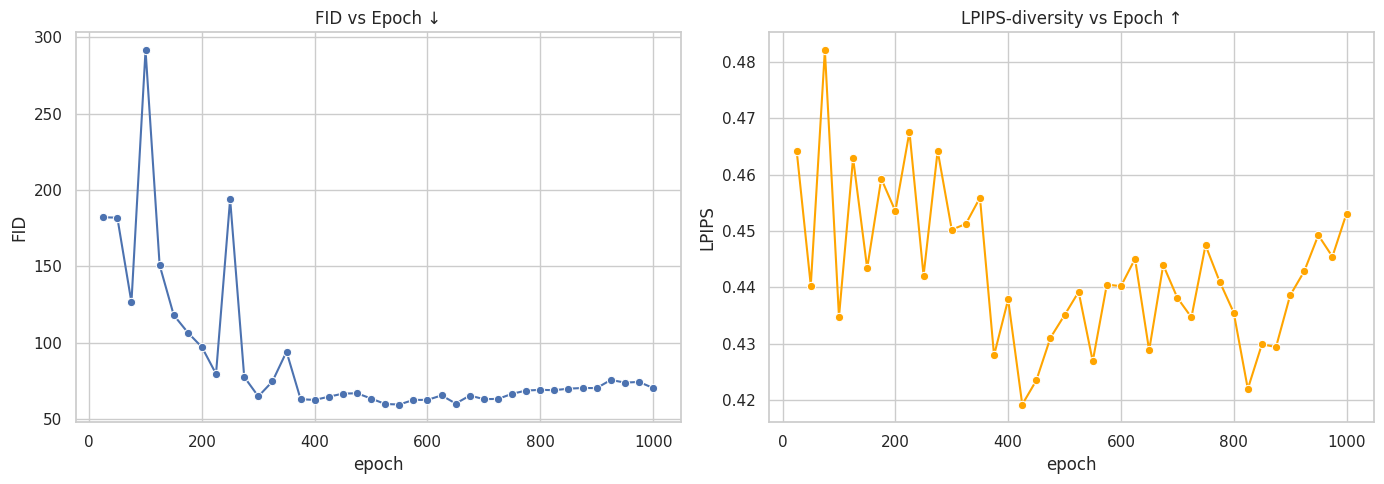

In [35]:
df = pd.read_csv(OUT_DIR/"scores.csv")

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.lineplot(df, x="epoch", y="FID", ax=axes[0], marker="o")
axes[0].set_title("FID vs Epoch ↓"); axes[0].set_ylabel("FID")

sns.lineplot(df, x="epoch", y="LPIPS", ax=axes[1], marker="o", color="orange")
axes[1].set_title("LPIPS-diversity vs Epoch ↑"); axes[1].set_ylabel("LPIPS")

plt.tight_layout(); plt.show()
